In [283]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import random
from math import pi

def vonMises(x, sigma):
    """The PDF of a von Mises distribution centered on 0."""
    return torch.exp((torch.cos(x)-1)/(2*sigma**2))

def circular(theta):
    """Wraps `theta` to [-pi,pi)."""
    return (theta+pi)%(2*pi)-pi

def paddedRandomAngles(n, delta):
    """`n` random angles [-pi,pi) with `delta` minimum pairwise angular distance.

    Args:
        n (int): number of angles.
        delta (float): minimum pairwise angular distance, in radians.

    Returns:
        angles ([float]): the list of angles.
    """
    angles = torch.tensor([])
    i = 0
    while len(angles)<n:
        potentialAngle = 2*pi*torch.rand(1)-pi
        if all(abs(circular(potentialAngle - angles)) > delta):
            angles = torch.cat((angles, potentialAngle))
    return angles

def randomWalk(steps, x0, vMax, aMax, aSigma):
    """Normally-distributed zero-mean acceleration on a cirle, with magnitude-
    clipped acceleration and velocity, starting from rest.
    
    Args:
        steps (int): duration of the walk, in steps.
        x0 (float): initial position.
        vMax (float): maximum velocity, in radians/step.
        aMax (float): maximum acceleration, in radians/step^2.
        aSigma (float): standard deviation of acceleration, in radians/step^2.

    Yields:
        x (float): position.
    """
    x = x0
    v = 0
    output = torch.zeros(steps)
    for step in range(steps):
        output[step] = x
        v += max(-aMax, min(aMax, random.gauss(0, aSigma)))
        v  = max(-vMax, min(vMax, v))
        x += v
    return output
        
N_INPUT = 80
N_HIDDEN = 128
N_OUTPUT = 70

N_STEPS = 100
N_TRIALS = 20
N_EPOCHS = 500

vMax = pi/10 #rad/step
aMax = pi/100 #rad/step^2
xSigma = pi/6 #rad
lSigma = pi/50 #rad
vSigma = vMax/10 #rad/step
aSigma = pi/400 #rad/step^2
delta = pi/9 #rad
dMin = pi/20 #rad
zMin = 0.2*torch.rand(N_INPUT-N_OUTPUT)
zMax = 0.2*torch.rand(N_INPUT-N_OUTPUT)+0.8

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.rnn = torch.nn.RNN(N_INPUT, N_HIDDEN, batch_first=True)
        self.linear = torch.nn.Linear(N_HIDDEN, N_OUTPUT)
        self.tanh = torch.nn.Tanh()
    
    def forward(self, input):
        return self.tanh(self.linear(self.rnn(input)[0]))
    
network = Network()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)

def createBatch(n_trials, n_steps, n_input, n_output):

    input = torch.zeros(n_trials, n_steps, n_input)
    target = torch.zeros(n_trials, n_steps, n_output)
    landmarks = []

    for trial in range(n_trials):
        landmarks.append(paddedRandomAngles(random.randint(2, 5), delta))
        x0 = random.random()*2*pi-pi
        for step, x in enumerate(circular(randomWalk(n_steps, x0, vMax, aMax, aSigma))):
            v = circular(x-x0)
            x0 = x
            input[trial,step,:-n_output] = torch.lerp(zMin, zMax, (v + random.gauss(0, vSigma))/(2*vMax)+0.5)
            if any(abs(circular(landmarks[trial]-x)) < dMin):
                input[trial,step,-n_output:] = vonMises(circular(x-torch.linspace(-pi, pi*(1-2/n_output), n_output) + random.gauss(0, lSigma)), xSigma)
            target[trial,step,:] = vonMises(circular(x-torch.linspace(-pi, pi*(1-2/n_output), n_output)), xSigma)
            
    return (input, target, landmarks)

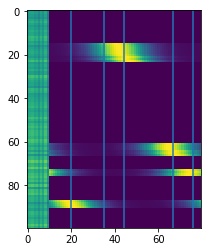

In [288]:
input, target, landmarks = createBatch(N_TRIALS, N_STEPS, N_INPUT, N_OUTPUT)

plt.imshow(input[0,:,:])
for landmark in landmarks[0]:
    plt.axvline((landmark+pi)/(2*pi)*N_OUTPUT+N_INPUT-N_OUTPUT)
plt.show()

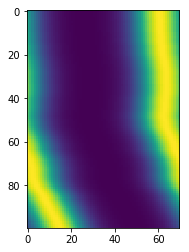

In [287]:
plt.imshow(target[0,:,:])

In [128]:
losses = []
for epoch in range(N_EPOCHS):
    
    input, target, landmarks = createBatch(N_TRIALS, N_STEPS, N_INPUT, N_OUTPUT)
            
    output = network(input)

    loss = criterion(output, target)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(network.parameters(), 100)
    if epoch%100==0:
        ax.scatter(epoch, loss.item())
    fig.canvas.draw()
    optimizer.step()

TypeError: createBatch() takes exactly 4 arguments (0 given)